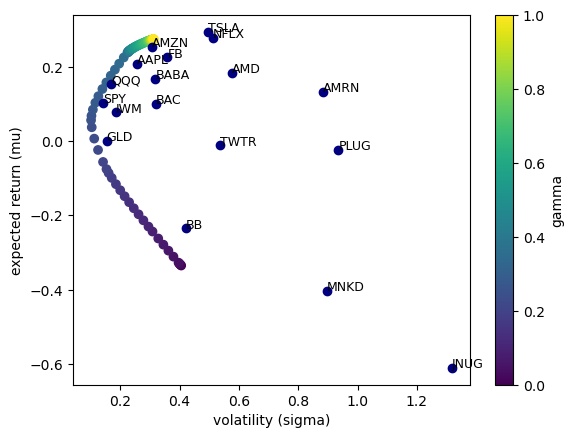

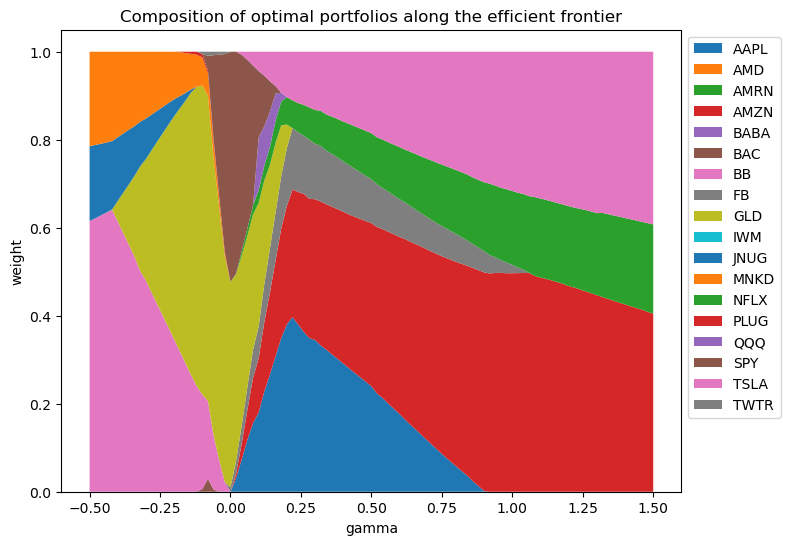

In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, LinearConstraint, Bounds
import matplotlib.pyplot as plt

def sample_mu_sigma(returns: pd.DataFrame, annualize = 1):
    if not isinstance(returns, pd.DataFrame):
        returns = pd.DataFrame(returns)
    
    expected_returns = np.mean(returns, axis=0) * annualize
    sample_covariance = returns.cov(ddof=0) * annualize
    return expected_returns, sample_covariance

def gamma_minimize(weights: np.ndarray, expected_returns: np.ndarray, sample_covariance: np.ndarray, gamma: float) -> float:
    return 0.5 * np.dot(weights.T, np.dot(sample_covariance, weights)) - gamma * np.dot(expected_returns, weights)

def gamma_jacobian(weights: np.ndarray, expected_returns: np.ndarray, sample_covariance: np.ndarray, gamma: float) -> np.ndarray:
    return np.dot(sample_covariance, weights) - gamma * expected_returns

def gamma_hessian(weights: np.ndarray, expected_returns: np.ndarray, sample_covariance: np.ndarray, gamma: float) -> np.ndarray:
    return sample_covariance

def efficient_frontier(gamma, expected_returns, sample_covariance, initial_guess=None):
    dimension = sample_covariance.shape[0]
    if initial_guess is None:
        initial_guess = np.ones(dimension) / dimension

    constraints = [LinearConstraint(np.ones(dimension), 1, 1)]
    bounds = Bounds(0, 1)

    result = minimize(gamma_minimize, 
                      initial_guess, 
                      args=(expected_returns, sample_covariance, gamma), 
                      jac=gamma_jacobian,
                    #   hess=gamma_hessian, # off for SLSQP
                      constraints=constraints,
                      bounds=bounds,
                      method='SLSQP' # SLSQP or trust-constr
                      )

    optimized_weights = result.x
    optimized_volatility = np.sqrt(np.dot(optimized_weights.T, np.dot(sample_covariance, optimized_weights)))
    mu_optimized = np.dot(optimized_weights.T, expected_returns)
    return mu_optimized, optimized_volatility, optimized_weights

path = '/Users/ivankhalin/Documents/code/MA3/QARM/Lab 2/sentratio_and_price_st.csv'
df = pd.read_csv(path, index_col=0)
df.index = pd.to_datetime(df.index)
df = df[df['ticker'] != 'UVXY']
tickers = df['ticker'].unique()

returns = df.pivot(columns='ticker', values='daily_return')
returns = np.log1p(returns)
expected_returns, sample_covariance = sample_mu_sigma(returns, 252)

data = []
gammas = np.linspace(-0.5, 1.5, 101)
for gamma in gammas:
    mu, sigma, weights = efficient_frontier(gamma, expected_returns, sample_covariance)
    data.append({
        'gamma': gamma,
        'mu': mu,
        'sigma': sigma,
        'weights': weights
    })

efficient_frontier_data = pd.DataFrame(data)
efficient_frontier_data.set_index('gamma', inplace=True)

# ------------------- Plotting ------------------- #

plt.scatter(efficient_frontier_data['sigma'], efficient_frontier_data['mu'], c=efficient_frontier_data.index)
plt.scatter(np.sqrt(np.diag(sample_covariance)), expected_returns, c='navy')
plt.xlabel('volatility (sigma)')
plt.ylabel('expected return (mu)')
plt.colorbar(label='gamma')
for i in range(len(tickers)):
    plt.text(np.sqrt(np.diag(sample_covariance))[i], expected_returns.iloc[i], tickers[i], fontsize=9)

weights_matrix = np.vstack(efficient_frontier_data['weights'].values).T
fig, ax = plt.subplots(figsize=(8, 6))
ax.stackplot(efficient_frontier_data.index, weights_matrix, labels=tickers)
ax.set_title('Composition of optimal portfolios along the efficient frontier')
ax.set_ylabel('weight')
ax.set_xlabel('gamma')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

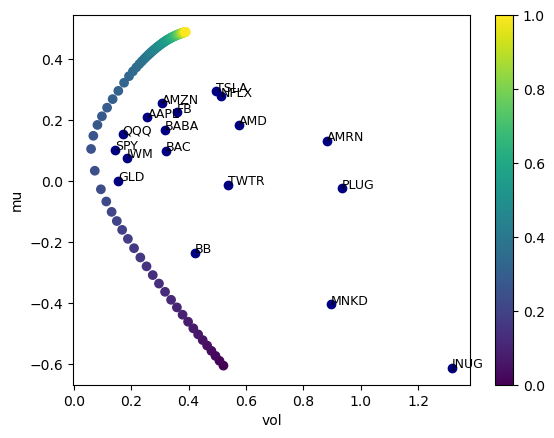

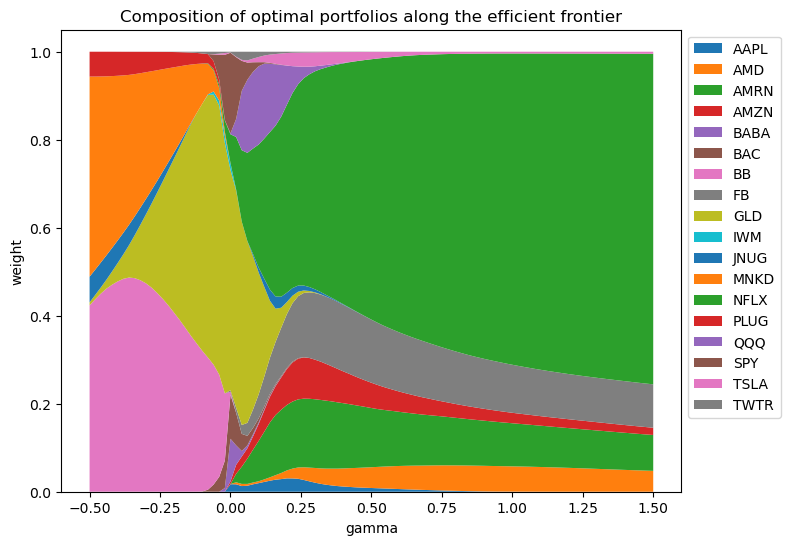

In [4]:
def get_portfolio(expected_returns, sample_covariance) -> pd.DataFrame:
    data = []
    # for gamma in np.linspace(-0.1, 3, 501):
    for gamma in np.linspace(-0.5, 1.5, 11):
        mu, sigma, weights = efficient_frontier(gamma, expected_returns, sample_covariance)
        data.append({
        'gamma': gamma,
        'mu': mu,
        'sigma': sigma,
        'weights': weights
        })
        
    efficient_frontier_data = pd.DataFrame(data)
    efficient_frontier_data.set_index('gamma', inplace=True)
    return efficient_frontier_data

def resample_portfolio(expected_returns, sample_covariance, n_simulations):
    simulation_dataframes = []
    dimension = sample_covariance.shape[0]
    for i in range(n_simulations):
        simulated_returns = np.random.multivariate_normal(expected_returns, sample_covariance, returns.shape[0]) # 1000 or returns.shape[0]
        expected_returns = np.mean(simulated_returns, axis=0)
        sample_covariance = np.cov(simulated_returns.T, ddof=0)
        efficient_frontier_data = get_portfolio(expected_returns, sample_covariance)
        simulation_dataframes.append(efficient_frontier_data)
    
    combined_simulation_data = pd.concat(simulation_dataframes)
    averaged_df = combined_simulation_data.groupby('gamma').agg({
        'mu': 'mean',
        'sigma': 'mean',
        'weights': lambda x: np.mean(np.stack(x), axis=0)
    })

    return averaged_df

n_simulations = 500
averaged_portfolio = resample_portfolio(expected_returns, sample_covariance, n_simulations)
efficient_frontier_data = pd.DataFrame(averaged_portfolio)

# ------------------- Plotting ------------------- #

plt.scatter(efficient_frontier_data['sigma'], efficient_frontier_data['mu'], c = efficient_frontier_data.index)
plt.scatter(np.sqrt(np.diag(sample_covariance)), expected_returns, c = 'navy')
plt.xlabel('vol')
plt.ylabel('mu')
plt.colorbar()
for i in range(len(tickers)):
    plt.text(np.sqrt(np.diag(sample_covariance))[i], expected_returns.iloc[i], tickers[i], fontsize=9)

weights_matrix = np.vstack(efficient_frontier_data['weights'].values).T
fig, ax = plt.subplots(figsize=(8, 6))
ax.stackplot(efficient_frontier_data.index, weights_matrix, labels=tickers)
ax.set_title('Composition of optimal portfolios along the efficient frontier')
ax.set_ylabel('weight')
ax.set_xlabel('gamma')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [5]:
print(returns.shape)

(2314, 18)


In [17]:
from scipy.optimize import NonlinearConstraint

def ERC(x, cov_matrix):
    abs_risk_contrib = x * (cov_matrix @ x) / np.sqrt(x.T @ cov_matrix @ x)
    return np.sum((abs_risk_contrib - np.mean(abs_risk_contrib))**2)

n = returns.shape[1]
bounds = Bounds(0, 1)
log_c = -n*np.log(n)
lc = LinearConstraint(np.ones(n), 1, 1)
nlc = NonlinearConstraint(lambda y: np.sum(y), lb=-n*np.log(n), ub=np.inf)
res = minimize(ERC, np.ones(n) / n, args=(sample_covariance), constraints=[lc], bounds=bounds, tol=1e-16, method='SLSQP')
print(res.x)
print(-n*np.log(n))
print(np.sum(np.log(res.x)))
print(ERC(res.x, sample_covariance))

[0.06202867 0.0311953  0.0290862  0.04960575 0.04961979 0.05558729
 0.03838199 0.05167322 0.22847204 0.06552421 0.02063908 0.02918467
 0.03760444 0.02786124 0.06499582 0.08299385 0.03787151 0.03767492]
-52.02669164213096
-55.157182530002444
1.3569517240118546e-16
